## Project Phase 1 - Aviation Accident Data Integration
### Group 03:
- Tommaso Tragno - fc64699
- Manuel Cardoso - fc56274
- Chen Cheng - fc64872
- Cristian Tedesco - fc65149

#### Setup

In [1]:
import pandas as pd
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import os
import time
import seaborn as sns
import calendar
import py_stringmatching as sm
import re

### 1. Data Loading

In [5]:
PATH = 'data_sources/'
FILTERED_PATH = 'filtered/'

NTSB_DATA = 'ntsb-us-2003-2023.json'
AIR_TRAFFIC_DATA = 'u-s-airline-traffic-data.csv'
AIRCRAFT_DATA = 'aircraft_data.csv' #'aircraft_data_cleaned.csv'
WEATHER_DATA = 'weather_results.json'

#### Load NTSB JSON Data

In [117]:
with open(PATH+NTSB_DATA, 'r', encoding='utf-8') as f:
    ntsb_raw_data = json.load(f)

# Each record is one accident/incident entry in a list
print(f'\n--- NTSB JSON loaded: {len(ntsb_raw_data)} total records found ---')

# Convert to a DataFrame (this will flatten top-level fields)
# For nested fields like 'Vehicles', we might do a separate flatten later
df_ntsb = pd.json_normalize(ntsb_raw_data, 
                            meta=[
                                'Oid','MKey','Closed','CompletionStatus','HasSafetyRec',
                                'HighestInjury','IsStudy','Mode','NtsbNumber',
                                'OriginalPublishedDate','MostRecentReportType','ProbableCause',
                                'City','Country','EventDate','State','Agency','BoardLaunch',
                                'BoardMeetingDate','DocketDate','EventType','Launch','ReportDate',
                                'ReportNum','ReportType','AirportId','AirportName','AnalysisNarrative',
                                'FactualNarrative','PrelimNarrative','FatalInjuryCount','MinorInjuryCount',
                                'SeriousInjuryCount','InvestigationClass','AccidentSiteCondition',
                                'Latitude','Longitude','DocketOriginalPublishDate'
                            ],
                            record_path=['Vehicles'],  # This flattens out the 'Vehicles' array
                            record_prefix='Vehicles.'
                           )

print('\n--- Flattened NTSB DataFrame (including Vehicles info): ---')

# print(df_ntsb.info())

# combines all injury counts to 1 column
df_ntsb['TotalInjuryCount'] = df_ntsb[['FatalInjuryCount', 'MinorInjuryCount', 'SeriousInjuryCount']].sum(axis=1)

# dropping unnecessary columns
df_ntsb.drop(columns=['AnalysisNarrative','FactualNarrative','PrelimNarrative','InvestigationClass','BoardLaunch'
                      ,'BoardMeetingDate','Launch','IsStudy','OriginalPublishedDate','DocketOriginalPublishDate'
                      ,'ReportType','ReportNum','ReportDate','MostRecentReportType','FatalInjuryCount','MinorInjuryCount'
                      ,'SeriousInjuryCount','DocketDate','Mode','HasSafetyRec','CompletionStatus','Closed'
                      ,'Vehicles.AircraftCategory','Vehicles.AmateurBuilt','Vehicles.EventID','Vehicles.AirMedical'
                      ,'Vehicles.AirMedicalType','Vehicles.flightScheduledType','Vehicles.flightServiceType'
                      ,'Vehicles.flightTerminalType','Vehicles.RegisteredOwner','Vehicles.RegulationFlightConductedUnder'
                      ,'Vehicles.RepGenFlag','Vehicles.RevenueSightseeing','Vehicles.SecondPilotPresent','Vehicles.Damage'
                      ,'AccidentSiteCondition'], inplace=True) 

# dropping NaT entries from EventDate
df_ntsb = df_ntsb.dropna(subset=['EventDate'])

# Type Conversion
df_ntsb['EventDate'] = pd.to_datetime(df_ntsb['EventDate']).dt.tz_localize(None)
df_ntsb['Vehicles.VehicleNumber'] = pd.to_numeric(df_ntsb['Vehicles.VehicleNumber'], errors='coerce').astype(int)
df_ntsb['MKey'] = pd.to_numeric(df_ntsb['MKey'], errors='coerce').astype(int)
df_ntsb['Vehicles.NumberOfEngines'] = pd.to_numeric(df_ntsb['Vehicles.NumberOfEngines'], errors='coerce').fillna(0).astype(int)
df_ntsb['Latitude'] = pd.to_numeric(df_ntsb['Latitude'], errors='coerce').astype(float)
df_ntsb['Longitude'] = pd.to_numeric(df_ntsb['Longitude'], errors='coerce').astype(float)
df_ntsb['TotalInjuryCount'] = pd.to_numeric(df_ntsb['TotalInjuryCount'], errors='coerce').astype(int)

categorical_cols = [
    'Vehicles.DamageLevel',
    'Vehicles.ExplosionType',
    'Vehicles.FireType',
    'HighestInjury',
    'EventType',
    'AccidentSiteCondition'
]

for col in categorical_cols:
    if col in df_ntsb.columns:
        df_ntsb[col] = df_ntsb[col].astype('category')

df_ntsb = df_ntsb.map(lambda x: x.lower() if isinstance(x, str) else x) # make all appropriate values lowercase

print(df_ntsb.info())

print('\n--- Saving filtered NTSB DataFrame... ---')
df_ntsb.to_pickle(PATH+'filtered/ntsb.pkl')


--- NTSB JSON loaded: 22992 total records found ---

--- Flattened NTSB DataFrame (including Vehicles info): ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23403 entries, 0 to 23402
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Vehicles.VehicleNumber        23403 non-null  int64         
 1   Vehicles.DamageLevel          23400 non-null  category      
 2   Vehicles.ExplosionType        21880 non-null  category      
 3   Vehicles.FireType             23321 non-null  category      
 4   Vehicles.SerialNumber         23283 non-null  object        
 5   Vehicles.Make                 23402 non-null  object        
 6   Vehicles.Model                23398 non-null  object        
 7   Vehicles.NumberOfEngines      23403 non-null  int64         
 8   Vehicles.RegistrationNumber   23397 non-null  object        
 9   Vehicles.FlightOperationType  21593 non-null  

#### Load Weather JSON Data
(after fetching the data from open-meteo API)

In [6]:
with open(PATH+WEATHER_DATA, 'r', encoding='utf-8') as f:
    weather_raw_data = json.load(f)

# Each record is one day weather entry in a list
print(f'\n--- Weather JSON loaded: {len(weather_raw_data)} total records found ---')

# weather_data is a dict, e.g.:
# {
#   "cen24la079_2023-12-31_41.610278_-90.588361": {
#       "time": [...],
#       "temperature_2m": [...],
#       ...
#   }
# }

# Flatten into a tabular structure
all_rows = []
num_skip = 0

for accident_id, subdict in weather_raw_data.items():
    # subdict is a dict with keys like "time", "temperature_2m", ...
    # Each key is an array of the same length (24 hours).
    times = subdict.get("time", None)
    if times is None:
        print(f'Skipping {accident_id}: no "time" found.')
        num_skip += 1
        continue
    num_hours = len(subdict["time"])
    for i in range(num_hours):
        row = {"AccidentID": accident_id}  # store the top-level key
        for param, values_array in subdict.items():
            # param: "time", "temperature_2m", ...
            row[param] = values_array[i]  # pick the ith hour’s value
        all_rows.append(row)

df_weather = pd.DataFrame(all_rows)

# The missing values exists because not all accident have position data
# this cause the api to return empty data.
print("Skipped {} records over {} accidents.".format(num_skip, len(weather_raw_data.items())))

# Type conversion
df_weather["time"] = pd.to_datetime(df_weather["time"], errors="coerce")

int_columns = [
    "relative_humidity_2m",
    "cloud_cover_low",
    "cloud_cover_mid",
    "cloud_cover_high",
    "wind_direction_10m",
    "wind_direction_100m",
    "weather_code"
]
float_columns = [
    "temperature_2m",
    "dew_point_2m",
    "pressure_msl",
    "surface_pressure",
    "precipitation",
    "rain",
    "snowfall",
    "wind_speed_10m",
    "wind_speed_100m",
    "wind_gusts_10m",
    "snow_depth"
]
for col in int_columns:
    df_weather[col] = pd.to_numeric(df_weather[col], errors="coerce").astype(int)
for col in float_columns:
    df_weather[col] = pd.to_numeric(df_weather[col], errors="coerce").astype(float)


print("\n--- Weather DataFrame sample ---")
print(df_weather.info())

print('\n--- Saving filtered Weather DataFrame... ---')
df_weather.to_pickle(PATH+'filtered/weather.pkl')


--- Weather JSON loaded: 20790 total records found ---
Skipping dca23wa432_2023-08-30_nan_nan: no "time" found.
Skipping cen23la030_2022-11-06_43511185.0_-1004241.0: no "time" found.
Skipping cen23la029_2022-11-02_390408.0_-953721.0: no "time" found.
Skipping cen23la020_2022-10-26_36940.21_-932048.49: no "time" found.
Skipping cen22la385_2022-08-10_43.12951_-85.67947: no "time" found.
Skipping cen22la310_2022-07-10_41.349_-894627.0: no "time" found.
Skipping cen22la180_2022-04-14_30.746616_-95.587956: no "time" found.
Skipping dca22wa057_2021-11-30_nan_nan: no "time" found.
Skipping dca21wa207_2021-08-14_nan_nan: no "time" found.
Skipping wpr21la163_2021-04-18_4603.0_-1041.12: no "time" found.
Skipping era18la213_2018-07-25_33.938888_-81.119445: no "time" found.
Skipping dca18wa177_2018-05-08_nan_nan: no "time" found.
Skipping cen16la033_2015-11-06_30.240554_-90.915275: no "time" found.
Skipping era16fa033_2015-11-06_27.2075_-80.842498: no "time" found.
Skipping era16fa032_2015-11-05_

#### Load Airline Traffic CSV Data

In [118]:
df_airline_traffic = pd.read_csv(PATH+AIR_TRAFFIC_DATA, encoding='utf-8')

print(f'\n--- Airline CSV loaded: {df_airline_traffic.shape[0]} rows, {df_airline_traffic.shape[1]} columns ---')

# dropping unnecessary columns
df_airline_traffic.drop(columns=['Dom_RPM','Int_RPM','RPM','Dom_ASM','Int_ASM','ASM','Dom_LF','Int_LF','LF'], inplace=True) 

# print(df_airline_traffic.info())

# Remove commas from all columns and then convert
df_airline_traffic = df_airline_traffic.replace(',', '', regex=True)

# Now convert each column to numeric. If everything converts well, no rows become NaN.
df_airline_traffic = df_airline_traffic.apply(pd.to_numeric, errors='coerce').astype(int)

print(df_airline_traffic.info())

print('\n--- Saving filtered Airline DataFrame... ---')
df_airline_traffic.to_pickle(PATH+'filtered/airline.pkl')


--- Airline CSV loaded: 249 rows, 17 columns ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Year     249 non-null    int64
 1   Month    249 non-null    int64
 2   Dom_Pax  249 non-null    int64
 3   Int_Pax  249 non-null    int64
 4   Pax      249 non-null    int64
 5   Dom_Flt  249 non-null    int64
 6   Int_Flt  249 non-null    int64
 7   Flt      249 non-null    int64
dtypes: int64(8)
memory usage: 15.7 KB
None

--- Saving filtered Airline DataFrame... ---


#### Load Aircraft CSV Data

In [20]:
df_aircraft = pd.read_csv(PATH+AIRCRAFT_DATA, encoding='utf-8')

print(f'\n--- Aircraft CSV loaded: {df_aircraft.shape[0]} rows, {df_aircraft.shape[1]} columns ---')

# print(df_aircraft.info())

# dropping unnecessary columns
df_aircraft.drop(columns=['Unnamed: 0'], inplace=True)
df_aircraft.drop(columns=['retired'], inplace=True)

# make string values lowercase
df_aircraft['aircraft'] = df_aircraft['aircraft'].str.lower()

# Type Conversion
df_aircraft['nbBuilt'] = pd.to_numeric(df_aircraft['nbBuilt'], errors='coerce').astype(int)
df_aircraft['startDate'] = pd.to_numeric(df_aircraft['startDate'], errors='coerce').astype(int)
df_aircraft['endDate'] = pd.to_numeric(df_aircraft['endDate'], errors='coerce').astype('Int64')  # Use 'Int64' for nullable integers

print(df_aircraft.info())

print('\n--- Saving filtered Aircraft DataFrame... ---')
df_aircraft.to_pickle(PATH+'filtered/aircraft.pkl')


--- Aircraft CSV loaded: 1266 rows, 6 columns ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1266 entries, 0 to 1265
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   aircraft   1266 non-null   object
 1   nbBuilt    1266 non-null   int64 
 2   startDate  1266 non-null   int64 
 3   endDate    997 non-null    Int64 
dtypes: Int64(1), int64(2), object(1)
memory usage: 40.9+ KB
None

--- Saving filtered Aircraft DataFrame... ---


### 2. Data Profiling

In [8]:
def profile_dataframe(df, name='DataFrame'):
    print(f'\n=== Profiling {name} ===')
    print(f'Total Rows: {len(df)}')
    print(f'Total Columns: {len(df.columns)}\n')
    
    profile_results = []

    for col in df.columns:
        series = df[col]
        col_dtype = series.dtype
        
        # Basic counts
        total_count = len(series)
        missing_vals = series.isna().sum()
        non_null_count = total_count - missing_vals
        missing_perc = (missing_vals / total_count) * 100
        unique_vals = series.nunique(dropna=False)
        
        # Mode & frequency
        try:
            modes = series.mode(dropna=True)
            mode_val = modes.iloc[0] if len(modes) > 0 else np.nan
            mode_freq = (series == mode_val).sum(skipna=True)
        except:
            mode_val, mode_freq = np.nan, np.nan
        
        # Initialize placeholders
        mean_ = np.nan
        min_  = np.nan
        q25   = np.nan
        q50   = np.nan
        q75   = np.nan
        max_  = np.nan
        std_  = np.nan  # only for numeric columns

        # Numeric columns
        if pd.api.types.is_numeric_dtype(series):
            mean_ = series.mean(skipna=True)
            min_  = series.min(skipna=True)
            q25   = series.quantile(0.25)
            q50   = series.quantile(0.50)
            q75   = series.quantile(0.75)
            max_  = series.max(skipna=True)
            std_  = series.std(skipna=True)

        # Datetime columns
        elif pd.api.types.is_datetime64_any_dtype(series):
            # We can compute mean & quartiles by time. 
            # .quantile() and .mean() are valid for datetime in pandas
            # They return a Timestamp for mean, 
            # and Timestamps for quantiles
            if non_null_count > 0:
                mean_ = series.mean(skipna=True)
                min_  = series.min(skipna=True)
                q25   = series.quantile(0.25)
                q50   = series.quantile(0.50)
                q75   = series.quantile(0.75)
                max_  = series.max(skipna=True)
            # We skip std_ for datetime.

        # Categorical/object columns 
        # do not get numeric stats (we keep them as NaN).

        profile_results.append((
            col,
            str(col_dtype),
            total_count,
            non_null_count,
            missing_vals,
            round(missing_perc, 2),
            unique_vals,
            mode_val,
            mode_freq,
            mean_,
            min_,
            q25,
            q50,
            q75,
            max_,
            std_
        ))

    columns = [
        'Column', 'DataType', 'TotalCount', 'NonNullCount', 'NumMissing',
        'MissingPerc', 'Cardinality', 'Mode', 'ModeFreq',
        'Mean', 'Min', 'Q25', 'Q50', 'Q75', 'Max', 'Std'
    ]

    prof_df = pd.DataFrame(profile_results, columns=columns)
    
    return prof_df

#### NTSB Data Profile

In [121]:
ntsb_profile = profile_dataframe(df_ntsb, name='NTSB Data')
display(HTML(ntsb_profile.to_html()))
ntsb_profile.to_csv(PATH+'profiling/ntsb_profile.csv', index=False)


=== Profiling NTSB Data ===
Total Rows: 23403
Total Columns: 27



,Column,DataType,TotalCount,NonNullCount,NumMissing,MissingPerc,Cardinality,Mode,ModeFreq,Mean,Min,Q25,Q50,Q75,Max,Std
0,Vehicles.VehicleNumber,int64,23403,23403,0,0.00,3,1,22986,1.018117,1,1.0,1.0,1.0,3,0.135603
1,Vehicles.DamageLevel,category,23403,23400,3,0.01,6,substantial,19718,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Vehicles.ExplosionType,category,23403,21880,1523,6.51,6,none,21306,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Vehicles.FireType,category,23403,23321,82,0.35,7,none,20993,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Vehicles.SerialNumber,object,23403,23283,120,0.51,21514,001,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Vehicles.Make,object,23403,23402,1,0.00,1098,cessna,8191,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Vehicles.Model,object,23403,23398,5,0.02,3362,172,762,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Vehicles.NumberOfEngines,int64,23403,23403,0,0.00,5,1,19416,1.13823,0,1.0,1.0,1.0,4,0.422117
8,Vehicles.RegistrationNumber,object,23403,23397,6,0.03,22386,unreg,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Vehicles.FlightOperationType,object,23403,21593,1810,7.73,22,pers,14516,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Insights from the data profile results:

- there are some `null` values for Latitude and Longitude --> we keep like this, but they should be handled during the API calls to open-meteo
- there are less unique `NtsbNumber` than rows --> for incident where more than one aircraft is involved, the rows are duplicated with different values for Vehicles characteristic, and same value for incident data (look at the following example)

In [122]:
df_ntsb.loc[df_ntsb['NtsbNumber']=='ops24la011']

,Vehicles.VehicleNumber,Vehicles.DamageLevel,Vehicles.ExplosionType,Vehicles.FireType,Vehicles.SerialNumber,Vehicles.Make,Vehicles.Model,Vehicles.NumberOfEngines,Vehicles.RegistrationNumber,Vehicles.FlightOperationType,Vehicles.OperatorName,Oid,MKey,HighestInjury,NtsbNumber,ProbableCause,City,Country,EventDate,State,Agency,EventType,AirportId,AirportName,Latitude,Longitude,TotalInjuryCount
39,1,none,none,none,c0218,diamond aircraft ind inc,da20-c1,1,n857pa,None,diamond aircraft sales of kentucky llc,67ee2dab017de3d12ee03758,193529,NaN,ops24la011,None,north las vegas,usa,2023-12-09 13:06:00,nv,ntsb,occ,vgt,north las vegas,36.211268,-115.19968,0
40,2,none,none,none,1955,robinson helicopter,r44,1,n744af,None,skyline helicopter tours llc,67ee2dab017de3d12ee03758,193529,NaN,ops24la011,None,north las vegas,usa,2023-12-09 13:06:00,nv,ntsb,occ,vgt,north las vegas,36.211268,-115.19968,0


#### Weather Data Profile

In [9]:
weather_profile = profile_dataframe(df_weather, name='Weather Data')
display(HTML(weather_profile.to_html()))
weather_profile.to_csv(PATH+'profiling/weather_profile.csv', index=False)


=== Profiling Weather Data ===
Total Rows: 491592
Total Columns: 21



,Column,DataType,TotalCount,NonNullCount,NumMissing,MissingPerc,Cardinality,Mode,ModeFreq,Mean,Min,Q25,Q50,Q75,Max,Std
0,AccidentID,object,491592,491592,0,0.00,20483,anc04ca085_2004-08-04_65.697502_-156.351104,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,time,datetime64[ns],491592,491592,0,0.00,155280,2011-06-18 00:00:00,14,2013-08-13 21:55:37.157643008,2004-07-24 00:00:00,2008-08-17 17:45:00,2013-03-11 02:30:00,2018-06-19 07:00:00,2023-12-31 23:00:00,NaN
2,temperature_2m,float64,491592,491592,0,0.00,806,23.5,1994,15.903267,-36.0,9.1,17.3,23.9,46.2,10.640686
3,relative_humidity_2m,int64,491592,491592,0,0.00,100,84,8307,64.547621,1,49.0,68.0,83.0,100,22.852449
4,dew_point_2m,float64,491592,491592,0,0.00,659,11.4,1969,7.872516,-39.5,0.9,8.9,15.9,27.6,10.155472
5,pressure_msl,float64,491592,491592,0,0.00,820,1015.6,3616,1015.685346,962.4,1011.8,1015.6,1019.7,1053.2,6.923077
6,surface_pressure,float64,491592,491592,0,0.00,3907,1014.0,1154,967.432852,602.2,958.7,990.6,1008.8,1041.5,62.377769
7,precipitation,float64,491592,491592,0,0.00,163,0.0,442059,0.074952,0.0,0.0,0.0,0.0,37.0,0.456493
8,rain,float64,491592,491592,0,0.00,163,0.0,446844,0.069873,0.0,0.0,0.0,0.0,37.0,0.450826
9,snowfall,float64,491592,491592,0,0.00,44,0.0,484116,0.003738,0.0,0.0,0.0,0.0,3.78,0.048473


#### Air Traffic Data Profile

In [123]:
airline_profile = profile_dataframe(df_airline_traffic, name='Airline Data')
display(HTML(airline_profile.to_html()))
airline_profile.to_csv(PATH+'profiling/airline_profile.csv', index=False)


=== Profiling Airline Data ===
Total Rows: 249
Total Columns: 8



,Column,DataType,TotalCount,NonNullCount,NumMissing,MissingPerc,Cardinality,Mode,ModeFreq,Mean,Min,Q25,Q50,Q75,Max,Std
0,Year,int64,249,249,0,0.0,21,2003,12,2.012880e+03,2003,2008.0,2013.0,2018.0,2023,6.002817e+00
1,Month,int64,249,249,0,0.0,12,1,21,6.445783e+00,1,3.0,6.0,9.0,12,3.442803e+00
2,Dom_Pax,int64,249,249,0,0.0,249,2877290,1,5.520971e+07,2877290,50982170.0,56200104.0,60892131.0,75378157,1.044055e+07
3,Int_Pax,int64,249,249,0,0.0,249,136609,1,7.392209e+06,136609,6395022.0,7419187.0,8567847.0,12432615,2.020273e+06
4,Pax,int64,249,249,0,0.0,249,3013899,1,6.260192e+07,3013899,57664576.0,63899130.0,69447429.0,87810772,1.229211e+07
5,Dom_Flt,int64,249,249,0,0.0,249,217262,1,7.067507e+05,217262,662000.0,709933.0,781804.0,890938,1.070550e+05
6,Int_Flt,int64,249,249,0,0.0,248,63469,2,6.473617e+04,4996,61615.0,66557.0,71924.0,82681,1.212962e+04
7,Flt,int64,249,249,0,0.0,249,222280,1,7.714869e+05,222280,727898.0,779011.0,848650.0,964102,1.156867e+05


#### Aircraft Data Profile

In [21]:
aircraft_profile = profile_dataframe(df_aircraft, name='Aircraft Data')
display(HTML(aircraft_profile.to_html()))
aircraft_profile.to_csv(PATH+'profiling/aircraft_profile.csv', index=False)


=== Profiling Aircraft Data ===
Total Rows: 1266
Total Columns: 4



,Column,DataType,TotalCount,NonNullCount,NumMissing,MissingPerc,Cardinality,Mode,ModeFreq,Mean,Min,Q25,Q50,Q75,Max,Std
0,aircraft,object,1266,1266,0,0.00,1265,mcdonnell douglas f-4 phantom ii in uk service,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,nbBuilt,int64,1266,1266,0,0.00,633,1,69,1252.535545,0.0,32.25,185.0,703.00,43400.0,3618.899938
2,startDate,int64,1266,1266,0,0.00,123,1936,33,1929.436019,1.0,1937.00,1951.0,1974.75,2015.0,224.918816
3,endDate,Int64,1266,997,269,21.25,119,1945,51,1930.302909,1.0,1938.00,1949.0,1979.00,2016.0,227.826756


Insights from the data profile results:

- there are some `startDate` and `endDate` equal to 1 --> it is supposed to be a year

In [22]:
df_filtered = df_aircraft[(df_aircraft['startDate'] < 1000) | (df_aircraft['endDate'] < 1000)]
df_filtered.style.map(
    lambda val: 'background-color: red' if val < 1000 else '',
    subset=['startDate', 'endDate']
)

,aircraft,nbBuilt,startDate,endDate
82,lockheed c-5 galaxy,131,5,5
86,british aerospace nimrod aew3,8,11,11
171,schneider es-57 kingfisher,11,2,
190,bell 222,230,222,1991
284,flitfire,49,10,10
308,grumman c-2 greyhound,58,2,2
498,chu hummingbird,2,2,2
514,embraer legacy 500,500,500,
518,lockheed martin f-22 raptor,195,22,22
536,gallaudet d-4,2,2,2


### Charts

    Month       Flt Month_Name
0       1  15719309        Jan
1       2  14510406        Feb
2       3  16693640        Mar
3       4  15822706        Apr
4       5  16417155        May
5       6  16606399        Jun
6       7  17434916        Jul
7       8  17361760        Aug
8       9  15770979        Sep
9      10  15622573        Oct
10     11  14910368        Nov
11     12  15230023        Dec


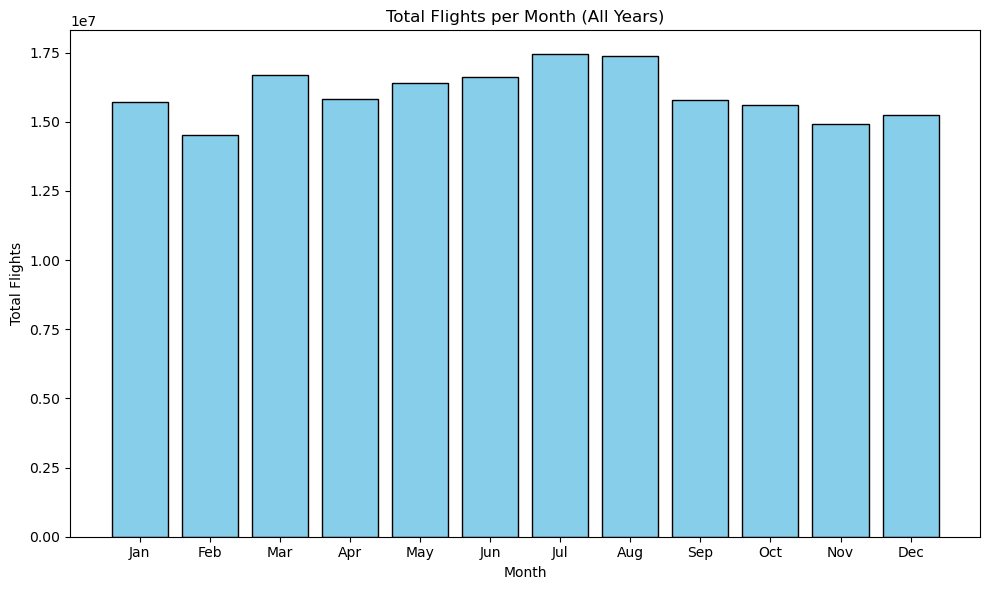

C:\Users\Errado\AppData\Local\Temp\ipykernel_15264\871914400.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_airline_pkl, x='Month_Name', y='Flt', order=month_order, palette='pastel')


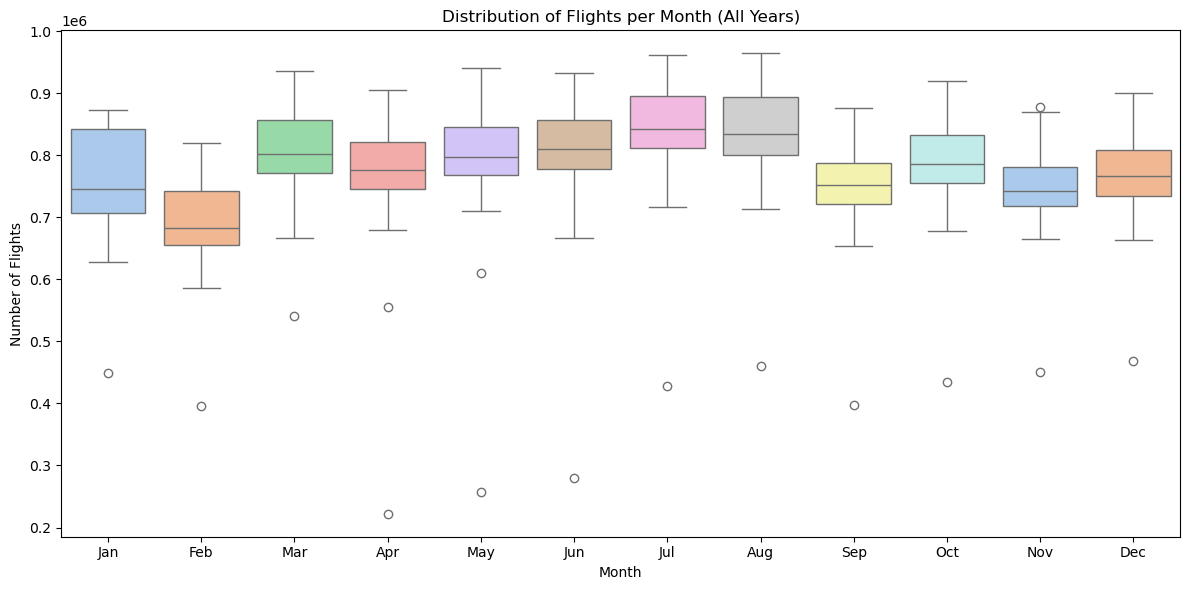

In [ ]:
df_airline = pd.read_pickle(PATH + FILTERED_PATH + 'airline.pkl')

# Group by 'Month' and sum 'Flt'
monthly_flt_sum = df_airline.groupby('Month')['Flt'].sum().reset_index()

# Sort by month to be sure
monthly_flt_sum = monthly_flt_sum.sort_values('Month')

# Map month numbers to names (Jan, Feb, ...)
month_names = [calendar.month_abbr[m] for m in monthly_flt_sum['Month']]
monthly_flt_sum['Month_Name'] = month_names

# Display result
print(monthly_flt_sum)

# Histogram
# Plot
plt.figure(figsize=(10, 6))
plt.bar(monthly_flt_sum['Month_Name'], monthly_flt_sum['Flt'], color='skyblue', edgecolor='black')

# Labels and title
plt.title('Total Flights per Month (All Years)')
plt.xlabel('Month')
plt.ylabel('Total Flights')

plt.tight_layout()
plt.show()

# Box Plot
# Map numeric month to abbreviation
df_airline['Month_Name'] = df_airline['Month'].apply(lambda x: calendar.month_abbr[x])

# Optional: Order months correctly
month_order = list(calendar.month_abbr)[1:]  # ['Jan', 'Feb', ..., 'Dec']

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_airline, x='Month_Name', y='Flt', order=month_order, palette='pastel')

# Labels and title
plt.title('Distribution of Flights per Month (All Years)')
plt.xlabel('Month')
plt.ylabel('Number of Flights')

plt.tight_layout()
plt.show()

## A blocking strategy

In [4]:
def clean_text(s):
    return re.sub(r'\W+', ' ', str(s)).lower().strip()

In [ ]:
# === 1. Caricamento Dataset ===
df_aircraft = pd.read_pickle(PATH+FILTERED_PATH+'aircraft.pkl')
df_ntsb = pd.read_pickle(PATH+FILTERED_PATH+'ntsb.pkl')
df_ntsb_model = df_ntsb[['NtsbNumber', 'EventDate', 'Vehicles.SerialNumber',
                         'Vehicles.RegistrationNumber', 'Vehicles.Make', 'Vehicles.Model']].copy()

# === 2. Pulizia e normalizzazione ===
df_ntsb_model['Vehicles.Model'] = df_ntsb_model['Vehicles.Model'].apply(clean_text)
df_aircraft['aircraft'] = df_aircraft['aircraft'].apply(clean_text)

df_ntsb_model.dropna(subset=['Vehicles.Model'], inplace=True)
df_aircraft.dropna(subset=['aircraft'], inplace=True)

# === 3. Setup Similarità ===
jw = sm.JaroWinkler()
lev = sm.Levenshtein()
jac = sm.Jaccard()
qgram = sm.QgramTokenizer(qval=3)

# === 4. Matching con q-gram + filtro numerico ===
df_ntsb_model['qgrams'] = df_ntsb_model['Vehicles.Model'].apply(lambda x: set(qgram.tokenize(x)))
df_aircraft['qgrams'] = df_aircraft['aircraft'].apply(lambda x: set(qgram.tokenize(x)))
matches = []

for i, ntsb_row in df_ntsb_model.iterrows():
    model_ntsb = ntsb_row['Vehicles.Model']
    grams_ntsb = ntsb_row['qgrams']

    for j, aircraft_row in df_aircraft.iterrows():
        model_aircraft = aircraft_row['aircraft']
        grams_aircraft = aircraft_row['qgrams']

        # BLOCCO: almeno 2 q-gram in comune o una sottostringa
        blocking_pass = (
            len(grams_ntsb & grams_aircraft) >= 2 or
            model_aircraft in model_ntsb or
            model_ntsb in model_aircraft
        )

        if blocking_pass:
            # Filtro numerico: i numeri devono coincidere se presenti
            nums_ntsb = re.findall(r'\d+', model_ntsb)
            nums_aircraft = re.findall(r'\d+', model_aircraft)

            if nums_ntsb and nums_aircraft and nums_ntsb != nums_aircraft:
                continue  # i numeri non coincidono → scarto

            # Calcolo le 3 similarità
            jw_score = jw.get_sim_score(model_ntsb, model_aircraft)
            lev_score = lev.get_sim_score(model_ntsb, model_aircraft)
            jac_score = jac.get_sim_score(model_ntsb.split(), model_aircraft.split())

            # Regola lineare
            final_score = 0.4 * jw_score + 0.3 * lev_score + 0.3 * jac_score

            if final_score > 0.75:
                matches.append({
                    'NtsbNumber': ntsb_row['NtsbNumber'],
                    'startDate': aircraft_row['startDate'],
                    'Vehicles.SerialNumber': ntsb_row['Vehicles.SerialNumber'],
                    'Vehicles.RegistrationNumber': ntsb_row['Vehicles.RegistrationNumber'],
                    'Vehicles.Make': ntsb_row['Vehicles.Make'],
                    'Vehicles.Model': model_ntsb,
                    'Matched_Aircraft': model_aircraft,
                    'JW_Score': round(jw_score, 3),
                    'LEV_Score': round(lev_score, 3),
                    'JAC_Score': round(jac_score, 3),
                    'SimilarityScore': round(final_score, 4)
                })

# === 5. Output finale ===
if not matches:
    print("Nessun match trovato con le regole attuali.")
else:
    df_matches = pd.DataFrame(matches)
    print(f"Match trovati: {len(df_matches)}")
    print("Colonne:", df_matches.columns.tolist())
    df_matches = df_matches.sort_values(by='SimilarityScore', ascending=False)
    display(df_matches.head(25))

Match trovati: 38
Colonne: ['NtsbNumber', 'startDate', 'Vehicles.SerialNumber', 'Vehicles.RegistrationNumber', 'Vehicles.Make', 'Vehicles.Model', 'Matched_Aircraft', 'JW_Score', 'LEV_Score', 'JAC_Score', 'SimilarityScore']


,NtsbNumber,startDate,Vehicles.SerialNumber,Vehicles.RegistrationNumber,Vehicles.Make,Vehicles.Model,Matched_Aircraft,JW_Score,LEV_Score,JAC_Score,SimilarityScore
4,gaa16ca444,1962,18830758,n65za,p z l -warszawa-cnpsl,pzl 104 wilga,pzl 104 wilga,1.000,1.000,1.000,1.0000
2,wpr22la106,1994,a267,n523ws,mckenzie john p,europa xs,europa xs,1.000,1.000,1.000,1.0000
37,nyc03wa057,1965,None,f-bvfa,aerospatiale,concorde,concorde,1.000,1.000,1.000,1.0000
30,wpr09la151,1979,089,c-gcil,gates learjet corporation,learjet 55,learjet 55,1.000,1.000,1.000,1.0000
15,wpr13la314,1995,ac-102,n94c,luy wayman,lockwood aircam,lockwood aircam,1.000,1.000,1.000,1.0000
12,wpr14ca136,1983,ch2 1191 cwidio,n345mn,norman,quad city challenger,quad city challenger,1.000,1.000,1.000,1.0000
21,era11fa165,1967,eep/jp/165,n167sm,british aircraft corp,bac 167 strikemaster,bac strikemaster,0.960,0.800,0.667,0.8240
33,mia07la066,1962,00030015,n424hd,eads pzl warsza,pzl 104m wilga,pzl 104 wilga,0.986,0.929,0.500,0.8229
3,anc17fa004,1959,2068,n5308f,fairchild heli-porter,pilatus pc 6,pilatus pc 6 porter,0.926,0.632,0.750,0.7850
14,era14la098,1997,085,n720qs,israel aircraft industries,gulfstream 200,gulfstream g200,0.987,0.933,0.333,0.7747


#### All Match

In [8]:
display(df_matches)

,NtsbNumber,startDate,Vehicles.SerialNumber,Vehicles.RegistrationNumber,Vehicles.Make,Vehicles.Model,Matched_Aircraft,JW_Score,LEV_Score,JAC_Score,SimilarityScore
4,gaa16ca444,1962,18830758,n65za,p z l -warszawa-cnpsl,pzl 104 wilga,pzl 104 wilga,1.000,1.000,1.000,1.0000
2,wpr22la106,1994,a267,n523ws,mckenzie john p,europa xs,europa xs,1.000,1.000,1.000,1.0000
37,nyc03wa057,1965,None,f-bvfa,aerospatiale,concorde,concorde,1.000,1.000,1.000,1.0000
30,wpr09la151,1979,089,c-gcil,gates learjet corporation,learjet 55,learjet 55,1.000,1.000,1.000,1.0000
15,wpr13la314,1995,ac-102,n94c,luy wayman,lockwood aircam,lockwood aircam,1.000,1.000,1.000,1.0000
12,wpr14ca136,1983,ch2 1191 cwidio,n345mn,norman,quad city challenger,quad city challenger,1.000,1.000,1.000,1.0000
21,era11fa165,1967,eep/jp/165,n167sm,british aircraft corp,bac 167 strikemaster,bac strikemaster,0.960,0.800,0.667,0.8240
33,mia07la066,1962,00030015,n424hd,eads pzl warsza,pzl 104m wilga,pzl 104 wilga,0.986,0.929,0.500,0.8229
3,anc17fa004,1959,2068,n5308f,fairchild heli-porter,pilatus pc 6,pilatus pc 6 porter,0.926,0.632,0.750,0.7850
14,era14la098,1997,085,n720qs,israel aircraft industries,gulfstream 200,gulfstream g200,0.987,0.933,0.333,0.7747


In [9]:
df_matches.to_csv(PATH+"binding/matched_results.csv", index=False)

## Wheather Data Query
(for each NTSB accident, fetch the weather conditions from the open-meteo API)

In [4]:
# ------------------------------------------------------------------
# Configuration
# ------------------------------------------------------------------
PKL_FILE = PATH+"filtered/ntsb.pkl"
WEATHER_CACHE_FILE = PATH+"weather_results.json"
MAX_CALLS_PER_DAY = 10000
COST_PER_CALL = 1.9
REQUEST_TIMEOUT = 15                # Seconds to wait for server response
MAX_RETRIES_TIMEOUT = 3             # Retries for a single request on timeout
MAX_CONSECUTIVE_TIMEOUTS = 3        # If we fail 3 accidents in a row, we stop
SLEEP_ON_429_SECS = 60              # Wait time if we get a 429
RETRIES_ON_429 = 3                  # Number of times to retry after 429

# ------------------------------------------------------------------
# 1) Load the NTSB DataFrame
# ------------------------------------------------------------------
df_ntsb = pd.read_pickle(PKL_FILE)

unique_accidents = df_ntsb[["NtsbNumber","Latitude","Longitude","EventDate"]].drop_duplicates()

# ------------------------------------------------------------------
# 2) Load partial cached results (if any)
# ------------------------------------------------------------------
if os.path.exists(WEATHER_CACHE_FILE):
    with open(WEATHER_CACHE_FILE, 'r', encoding='utf-8') as f:
        weather_data_cache = json.load(f)
else:
    weather_data_cache = {}

calls_made_today = 0
consecutive_timeouts = 0  # Track consecutive accidents that fail all retries

# ------------------------------------------------------------------
# Helper function to perform the request with timeouts, retries, 429 handling
# ------------------------------------------------------------------
def fetch_weather_data(lat, lon, date_str, cache_key):
    """
    Attempt to fetch data up to MAX_RETRIES_TIMEOUT times if we get a timeout,
    and up to RETRIES_ON_429 times if we get status 429.
    Returns the 'hourly' data dict (or empty dict) if all attempts fail.
    Raises a custom "AllRetriesTimeout" exception if timeouts keep failing.
    """
    endpoint = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": date_str,
        "end_date": date_str,
        "hourly": ",".join([
            "temperature_2m","relative_humidity_2m","dew_point_2m","pressure_msl",
            "surface_pressure","precipitation","rain","snowfall","cloud_cover",
            "cloud_cover_low","cloud_cover_mid","cloud_cover_high","wind_speed_10m",
            "wind_speed_100m","wind_direction_10m","wind_direction_100m",
            "wind_gusts_10m","weather_code","snow_depth"
        ]),
        "timezone": "GMT"
    }

    timeout_attempts = 0

    while timeout_attempts < MAX_RETRIES_TIMEOUT:
        # We'll also keep track of 429 attempts
        status429_attempts = 0
        while True:
            try:
                # Perform the request with a timeout
                response = requests.get(endpoint, params=params, timeout=REQUEST_TIMEOUT)
                # Check HTTP status
                if response.status_code == 200:
                    return response.json().get("hourly", {})
                elif response.status_code == 429:
                    status429_attempts += 1
                    if status429_attempts <= RETRIES_ON_429:
                        print(f"[{cache_key}] Got 429. Waiting {SLEEP_ON_429_SECS}s then retrying (attempt {status429_attempts}/{RETRIES_ON_429}).")
                        time.sleep(SLEEP_ON_429_SECS)
                        continue  # Retry the same request
                    else:
                        print(f"[{cache_key}] Too many 429 responses. Giving up this accident.")
                        return {}
                else:
                    # Some other error status code
                    print(f"[{cache_key}] Request failed: {response.status_code}. Skipping.")
                    return {}
            except requests.exceptions.Timeout:
                timeout_attempts += 1
                if timeout_attempts < MAX_RETRIES_TIMEOUT:
                    print(f"[{cache_key}] Timed out attempt {timeout_attempts}/{MAX_RETRIES_TIMEOUT}. Retrying.")
                else:
                    print(f"[{cache_key}] Timed out {MAX_RETRIES_TIMEOUT} times. Giving up.")
                    # We'll raise to handle the "consecutive timeouts" logic in the main loop
                    raise TimeoutError("All timeouts used up")
            except Exception as e:
                print(f"[{cache_key}] Unexpected error: {e}")
                return {}

    # If we exit the loop by normal means, we return empty
    return {}

# ------------------------------------------------------------------
# Main Loop
# ------------------------------------------------------------------
try:
    for idx, row in unique_accidents.iterrows():
        ntsb_number = row["NtsbNumber"]
        date_str = pd.to_datetime(row["EventDate"]).strftime('%Y-%m-%d')
        lat = row["Latitude"]
        lon = row["Longitude"]
        cache_key = f"{ntsb_number}_{date_str}_{lat}_{lon}"

        # Skip if we already have data
        if cache_key in weather_data_cache:
            continue

        # Check daily limit
        if calls_made_today + COST_PER_CALL > MAX_CALLS_PER_DAY:
            print("Reached daily limit.")
            break

        # Attempt to fetch data
        try:
            data_hourly = fetch_weather_data(lat, lon, date_str, cache_key)
        except TimeoutError:
            # Means we timed out all attempts
            data_hourly = {}
            consecutive_timeouts += 1
            if consecutive_timeouts >= MAX_CONSECUTIVE_TIMEOUTS:
                print(f"Hit {MAX_CONSECUTIVE_TIMEOUTS} consecutive timeouts. Stopping the script.")
                break
        else:
            # If we didn't raise TimeoutError, reset consecutive timeouts
            consecutive_timeouts = 0

        # Store results (empty or not)
        weather_data_cache[cache_key] = data_hourly
        print(f"[{idx}] {cache_key} => {('SUCCESS' if data_hourly else 'FAILED')}")

        calls_made_today += COST_PER_CALL

        # Save partial results every 100
        if idx % 100 == 0:
            print(f"Processed {idx} accidents. Saving partial results.")
            with open(WEATHER_CACHE_FILE, 'w', encoding='utf-8') as f:
                json.dump(weather_data_cache, f)

except KeyboardInterrupt:
    print("\nInterrupted by user (Ctrl+C). Saving data and exiting...")

finally:
    # Always save final results to disk
    with open(WEATHER_CACHE_FILE, 'w', encoding='utf-8') as f:
        json.dump(weather_data_cache, f)
    print("Data saved to", WEATHER_CACHE_FILE)
    print("Done.")

[15811] nyc08ca321_2008-07-26_30.423889_-87.777496 => SUCCESS
[15812] chi08ca221_2008-07-25_47.211112_-93.516387 => SUCCESS
[15813] dfw08ca199_2008-07-25_35.958889_-91.169723 => SUCCESS
[15814] lax08fa244_2008-07-24_47.263889_-123.333053 => SUCCESS
[15815] chi08ca212_2008-07-24_40.317222_-89.75 => SUCCESS
[15816] den08ia123_2008-07-23_39.861667_-104.673057 => SUCCESS
[15817] chi08ca208_2008-07-23_39.880756_-83.440048 => SUCCESS
[15818] lax08ca247_2008-07-23_46.676944_-122.98278 => SUCCESS
[15819] chi08ca206_2008-07-23_42.953609_-85.34333 => SUCCESS
[15820] den08la128_2008-07-23_40.163612_-105.163055 => SUCCESS
[15821] lax08la240_2008-07-22_40.869445_-111.926666 => SUCCESS
[15822] nyc08la255_2008-07-22_26.518333_-80.041664 => SUCCESS
[15823] anc08la089_2008-07-22_59.753887_-154.911117 => SUCCESS
[15824] dfw08ca195_2008-07-22_32.983612_-91.203613 => SUCCESS
[15825] chi08ca226_2008-07-21_45.683887_-92.687225 => SUCCESS
[15826] lax08ca237_2008-07-21_45.123611_-113.866668 => SUCCESS
[15827]